In [6]:
import numpy as np
from dataframe import Data
from SNANA_FITS_to_pd import read_fits
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
from io_utils import *
from random import random
import matplotlib.animation as animation


In [7]:
dataset_val = 1

In [8]:
if dataset_val == 0:
    dataset =  "PLAsTiCC"
    data_ob = load_PLAsTiCC_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids=data_ob.get_ids_of_event_type(64)
    color_band_dict = {0:'C4',1:'C2', 2:'C3', 3:'C1', 4:'k', 5:'C5'}

In [9]:
if dataset_val == 1:    
    dataset = "ZTF"
    data_ob = load_ztf_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids = object_ids
    color_band_dict = {b'g ':'C2', b'r ':'C3'}

In [10]:
from LightCurve import LightCurve

In [11]:
def predict_lt_curve(coeff, PCs):
    predict_comb = np.zeros_like(PCs.shape[1])
    for a,b in zip(PCs,coeff): predict_comb=np.add(predict_comb,b*a)
    return predict_comb

In [12]:
def calc_loss(coeff, PCs, light_curve_seg, regularization_vals, max_flux):
    index = light_curve_seg!=0
    y_pred = predict_lt_curve(coeff,PCs)
    diff = light_curve_seg - y_pred
    neg_index = y_pred<0
    diff = diff[(index)|(neg_index)]
    
    #diff = diff[index]
    
    #error = np.sum(np.square(diff,diff)) + np.sum(np.square(regularization_vals-coeff/np.sum(coeff)))*1000
    error = np.sum(np.square(diff,diff))
    return error

In [13]:
print(len(object_ids))

def get_binned_time(df):
    return df[data_ob.time_col_name]-df[data_ob.time_col_name]%2

248


In [14]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit

PCs = np.load("principal_components/PCs.npy")

PCs = PCs[0:3]



In [15]:
def init(): 
    line.set_data([], [])
    line2.set_data([], [])
    return line1,line2

In [16]:
def rotatePCs(PCs):
    outputPCs = np.zeros_like(PCs)
    max_vals = np.argmax(PCs,axis = 1)
    print(max_vals)
    min_shift = np.amin(max_vals)
    print(min_shift)
    min_shift = 25- min_shift
    #for i in range(PCs.shape[0]):
        #print(PCs.shape[1])
    outputPCs[1][min_shift:] = PCs[1][:PCs.shape[1]-min_shift]
    return outputPCs

In [17]:
def plot_light_curve_progression(current_date, event_df, color):
    
    past_index = event_df[data_ob.time_col_name] <= current_date
    event_df = event_df[past_index]
    
    if(len(event_df)>0): 
        current_index = event_df[data_ob.time_col_name] == current_date
        current_flux = event_df[data_ob.flux_col_name][current_index]
        current_flux_err = event_df[data_ob.flux_err_col_name][current_index]

        max_flux_loc = np.argmax(event_df[data_ob.flux_col_name])

        date_of_max_flux = event_df[data_ob.time_col_name][max_flux_loc]
        max_flux = event_df[data_ob.flux_col_name][max_flux_loc]
        
        if date_of_max_flux<current_date:
            mid_point_date = date_of_max_flux
            PCs = np.load("principal_components/PCs.npy")
            PCs = PCs[0:3]
            initial_guess = [.93,.04 ,.012]
            regularization_base = [.93,.04,.012]
        else:
            mid_point_date = current_date
            PCs = np.load("principal_components/PCs.npy")
            PCs = PCs[0:3]
            initial_guess = [.93,.03 ,.025]
            regularization_base = [.93,.04,.012]
            #PCs = rotatePCs(PCs)
            
        start_date=mid_point_date-(no_of_predicted_days-1)*time_step/2 
        end_date= mid_point_date+(no_of_predicted_days-1)*time_step/2 
        start_index = band_df[data_ob.time_col_name] >= start_date
        end_index = band_df[data_ob.time_col_name] <= end_date 

        fit_df = event_df[start_index&end_index]
        
        if len(fit_df)>0:
            
            binned_dates = get_binned_time(fit_df)
            b2 = (binned_dates-mid_point_date+no_of_predicted_days-1)/2
            b2 = b2.astype(int)
            light_curve_seg = np.zeros((no_of_predicted_days))
            light_curve_seg[b2[:]] = fit_df[data_ob.flux_col_name]

            result = minimize(calc_loss, initial_guess, args=(PCs, light_curve_seg, regularization_base, max_flux))

    
            predicted_lt_curve = predict_lt_curve(result.x,PCs)
            x_data = np.arange(start_date,end_date+2,2)
            
            plt.errorbar(current_date, current_flux, current_flux_err, color=color_band_dict[band], fmt='o', label="points considered")
            
            line1.set_data(x_data, predicted_lt_curve)
                 
            line1.set_lw(2)
            #ax = plt.gca()
            #plt.label()
            return (line1,)
        
    line1.set_data([], [])
    return (line1,)

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindex

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to retur

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/biswajit/anaconda3/envs/fink/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr

KeyboardInterrupt: 

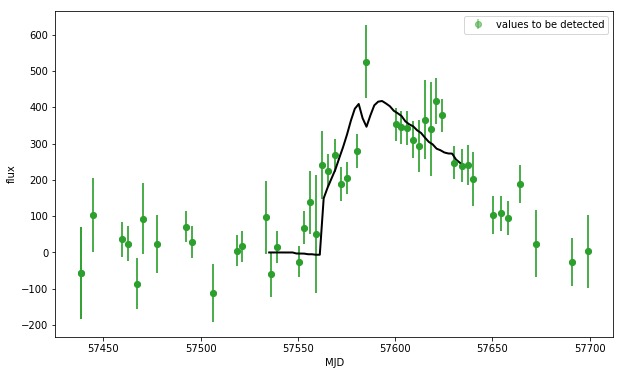

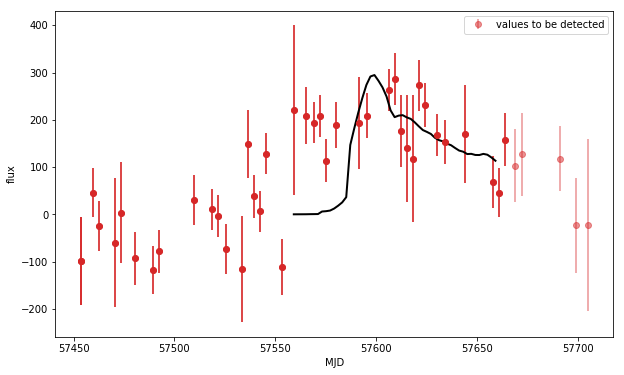

In [18]:
time_step = 2 
no_of_predicted_days = 51
count  = 0 


for object_id in object_ids:
    #print(object_id)
    event_df = data_ob.get_data_of_event(target=object_id)
    
    for band in data_ob.band_map.keys():
        
        band_index = event_df[data_ob.band_col_name] == band
        band_df = event_df[band_index]
        #print(band_df)
        time_col = np.asarray(band_df[data_ob.time_col_name])
        flux_col = np.asarray(band_df[data_ob.flux_col_name])
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=1)
            
            
        fig = plt.figure(figsize=(10,6))
        plt.xlabel("MJD")
        plt.ylabel("flux")
        plt.errorbar(band_df[data_ob.time_col_name], band_df[data_ob.flux_col_name], band_df[data_ob.flux_err_col_name], color=color_band_dict[band], fmt='o', label="values to be detected", alpha = 0.5)
        #Writer = animation.FFMpegWriter(fps=1, codec='libx264')
        line1, = plt.plot([], [], lw=2)
        line2, = plt.plot([], [], lw=2)
        line1.set_color("black")
        time0 = time_col[0]
        plt.legend()
        #x_t0, predict_time0 = predict_curve(event_df=event_df, mid_point_date=time0,number_of_days_to_predict=51,time_step=2)
        #predicted_line, = plt.plot(x_t0,predict_time0)
        anim = animation.FuncAnimation(fig, plot_light_curve_progression, frames = time_col, fargs=(band_df,color_band_dict[band]),interval=1000)
        anim.save("fit_vid/Prediction_mov"+ str(object_id) +"_same_PCs.mp4",writer=writer)
        
    plt.close('all')
        

In [ ]:
remember to take np.unique on iterations